In [2]:
from __future__ import print_function
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys,os
from scipy.stats import fisher_exact
import random

# directory to write otput
eQTL_dir = "../genetic_associations/eQTL/"

# 
gwas_dir = "../genetic_associations/GWAS/"
# this directory should contain .dbSNP150_b37common.rsid2variant.txt with \t-separated 
# chrom pos ref alt rsid
dbSNP_dir = "/home/olga/DATA/asthma_hypertension/version_3/genetic_associations/eQTL/GTEx_v6/GTEx_Analysis_v6p_eQTL/"


%matplotlib inline  

# This notebook 
 * Takes prepared eQTL data files and annotates them with rs IDs from dbSNP150
 * Extracts eQTLs overlapping with GWAS hits for asthma and hypertension and finds genes controlled by these eQTLs
 * Does permutations to prove that overlap between is much more than expected by chance 

In [4]:
def assign_dbSNP(row,dbsnp_dict):
    # add positional correction !!!
    pos = row["pos"]
    rsid_reported = row["rsid_reported"] 
    rsids = []
    # 1) search for matchig rsid in close proximity
    for i in [0,1,-1,2,-2]:
        try:
            rsids = dbsnp_dict[pos+i]
            if rsid_reported in rsids:
                return rsid_reported
        except:
            pass
    # 2) if no match take the first closest rsid or a group of rsids
    if len(rsids)>0:
        for i in [0,1,-1,2,-2]:
            try: 
                rsids = dbsnp_dict[pos+i]
                return ",".join(list(set(rsids)))
            except: 
                pass
    return None
        
    
def sort_and_assign_dbSNP(dfs):
    dfs["chrom"] = dfs["chrom"].apply(str)
    dfs["pos"] = dfs["pos"].apply(int)
    dfs2 = []
    for i in map(str,range(1,23))+["X","Y"]:
        i = str(i)
        df = dfs[dfs.chrom == i]
        if df.shape[0]>0:
            dbsnp_dict = {}
            prev_pos = 0
            with open(dbSNP_dir+str(i)+".dbSNP150_b37common.rsid2variant.txt","r") as infile:
                for line in infile:
                    line = line.rstrip().split("\t")
                    pos = int(line[1])
                    rsid = line[4]
                    if not pos == prev_pos:
                        dbsnp_dict[pos] = [rsid]
                        prev_pos = pos
                    else:
                        dbsnp_dict[pos] += [rsid]
            #print(i,len(dbsnp_dict.keys()))
            df["rsid"] = df.apply(lambda row : assign_dbSNP(row,dbsnp_dict),axis=1)
            print(i,df[df.cis_trans == "trans"].shape[0],df[df.cis_trans == "cis"].shape[0],"start sorting...")
            df = split_rows(df,"rsid",",")
            df.sort_values(by= ['pos'],ascending = [True], inplace = True)
            dfs2.append(df)
    dfs2  = pd.concat(dfs2)
    dfs2.index = range(0,dfs2.shape[0])
    dfs2.drop_duplicates(inplace = True) 
    return dfs2

def split_rows(df,col,sep):
    #df_null = df[df.rsid.isnull()]
    df2 = df[~df.rsid.isnull()]
    df_tosplit = df2[df2[col].str.contains(",")]
    df_keep = df2[~df2[col].str.contains(",")]
    print("initial rows:", df.shape[0],"rows without rsid:",df[df.rsid.isnull()].shape[0])
#      "rows to separate:",df_tosplit.shape[0], "intact:",df_keep.shape[0])
    if df_tosplit.shape[0]>0:
        s = df_tosplit[col].str.split(',').apply(pd.Series, 1).stack()
        s.index = s.index.droplevel(-1)
        s.name = col
        del df_tosplit[col]
        df_tosplit = df_tosplit.join(s)
    df2 = pd.concat([df_keep,df_tosplit])
    print("rows after separation:", df2.shape[0])
    return df2

## Assign dbSNP 150 rs IDs if necessary

If no rsid field provided, guesses dbSNP 150 rsid from rsid_reported and position
if more than 1 rsid available for a position, selects id matching with rsid_reported; 
    if none matches with rsid_reported, than reports all risds as separate records
    * ! this mapping approach is not fully correct, but it is suitable for our needs - we need only approximate SNP position and don't care about alleles
only common variants (>1%) considered
drop records failed to map to any rsid in dbSNP150 
assumes ref=hg19/GRCh37


In [ ]:
eQTLdb= []
for dataset in ["Westra_blood.FDR0.05.rsid.tsv","Jansen_blood.FDR0.05.rsid.tsv",
                "Joehanes_FHS.FDR0.05.rsid.tsv","GTEx_v6.FDR0.05.tsv"]:
    print(dataset)
    df = pd.read_csv(eQTL_dir+"db/"+dataset,sep="\t")
    df["chrom"] = df["chrom"].apply(str)
    df["pos"] = df["pos"].apply(int)
    if not "rsid" in df.columns:
        df = sort_and_assign_dbSNP(df)
        print("all records",df.shape[0],"no rsid",df[df.rsid.isnull()].shape[0])
        df = df[~df.rsid.isnull()]
        print("ambigous",df[df.rsid.str.contains(",")].shape[0])
        df.to_csv(out_dir+dataset+".FDR0.05.rsid.tsv",sep="\t",index = False)
    df =df[["chrom", "pos","rsid","rsid_reported","gene","tissue","source","cis_trans"]]
    print("\t"+" total : ",df.shape[0],"records ",
          "genes",len(set(df.gene.values)),"variants", len(set(df.rsid_reported.values)))
    df = df.drop_duplicates()
    print("\t"+" deduplicated : ",df.shape[0],"records ",
          "genes",len(set(df.gene.values)),"variants", len(set(df.rsid_reported.values)))
    eQTLdb.append(df)

Westra_blood.FDR0.05.rsid.tsv
	 total :  659998 records  genes 6750 variants 378075
	 deduplicated :  578540 records  genes 6750 variants 378075
Jansen_blood.FDR0.05.rsid.tsv
	 total :  3161130 records  genes 7176 variants 1200859
	 deduplicated :  2179126 records  genes 7176 variants 1200859
Joehanes_FHS.FDR0.05.rsid.tsv


In [7]:
eQTLdb= pd.concat(eQTLdb)
print("total eQTL records",eQTLdb.shape[0],"trans",eQTLdb[eQTLdb.cis_trans == "trans"].shape[0])
eQTLdb = eQTLdb[~eQTLdb.rsid.isnull()]
#print("with rsid ",eQTLdb.shape[0])

total eQTL records 34927900 trans 751757
with rsid  34927900


In [7]:
### unique records 
x = eQTLdb[["rsid","cis_trans","gene"]].drop_duplicates()
print("unique records:",x.shape[0],"cis:",x[x.cis_trans=="cis"].shape[0],"trans:",x[x.cis_trans=="trans"].shape[0])

unique records: 11313581 cis: 10582603 trans: 730978


In [8]:
gwas = {}
for disease in ["asthma","hypertension"]:
    rs = pd.read_csv(gwas_dir+disease+".full_GWAS.tsv",sep ="\t")[['CHR_ID','CHR_POS','SNPS','MAPPED_GENE',"CONTEXT","P-VALUE",'DISEASE/TRAIT',"PUBMEDID"]]
    rs = rs[~rs.CHR_ID.isnull()]
    gwas[disease] =  rs

for k in gwas.keys():
    print(k, "records", gwas[k].shape[0], "unique rsid",len(set(gwas[k]["SNPS"].values)))

hypertension records 144 unique rsid 105
asthma records 448 unique rsid 412


In [9]:
# asthma
a_rs  = set(gwas["asthma"]["SNPS"].values)
aeQTL = eQTLdb[eQTLdb.rsid.isin(a_rs)][["gene","rsid"]].drop_duplicates()
aeQTL_genes =set(aeQTL["gene"].values)
aeQTL_rs = set(aeQTL["rsid"].values)
print("Asthma   GWAS rs:",len(a_rs),"rs among eQTL:",len(aeQTL_rs),"controlled genes:",len(aeQTL_genes))
# hypertension
h_rs  = set(gwas["hypertension"]["SNPS"].values)
heQTL = eQTLdb[eQTLdb.rsid.isin(h_rs)][["gene","rsid"]].drop_duplicates()
heQTL_genes =set(heQTL["gene"].values)
heQTL_rs = set(heQTL["rsid"].values)
print("Hypertension GWAS rs:",len(h_rs),"rs among eQTL:",len(heQTL_rs)," contolled genes:",len(heQTL_genes))
# now many common SNPs and genes 
aheQTL_rs = heQTL_rs.intersection(aeQTL_rs)
aheQTL_genes = heQTL_genes.intersection(aeQTL_genes)
print("Common rs:",len(aheQTL_rs),"genes:",len(aheQTL_genes))
print("Common SNPs ",aheQTL_rs,"control only ",len(set(eQTLdb[eQTLdb.rsid.isin(aheQTL_rs)].gene.values)),"genes.")

Asthma   GWAS rs: 412 rs among eQTL: 140 controlled genes: 439
Hypertension GWAS rs: 105 rs among eQTL: 46  contolled genes: 213
Common rs: 1 genes: 110
Common SNPs  set(['rs3184504']) control only  39 genes.


In [10]:
### Do we have more eQTL controlled genes in intersection of H and A than expected?
def do_fisher(ab, a, b, N):
    return fisher_exact([[ab, a-ab], [b-ab, N-a-b+ab]],alternative="greater")
do_fisher(len(heQTL_genes.intersection(aeQTL_genes)), len(aeQTL_genes), len(heQTL_genes), len(set(eQTLdb['gene'].values)))

(99.158084221087734, 2.5389660581086602e-148)

In [11]:
def permute_eQTLs(eQTLdb,n1,n2,N,observed):
    """gets 2 random rsid sets of given sizes, 
    extract controled genes from eQTLdbs and counts overlaped genes.
    Does N permutations."""
    permuts = []
    all_rsid = set(eQTLdb['rsid'].values)
    for i in range(0,N):
        rs1 =  set(random.sample(all_rsid,n1))
        rs2 =  set(random.sample(all_rsid,n2))
        gs1  = set(eQTLdb[eQTLdb.rsid.isin(rs1)]['gene'].values)
        gs2  = set(eQTLdb[eQTLdb.rsid.isin(rs2)]['gene'].values)
        result = len(gs1.intersection(gs2))#,len(rs1.intersection(rs2))
        permuts.append(result)
    p_val = float(len([x for x in permuts if x >observed]))/N
    expected = float(sum(permuts))/N
    return permuts, p_val, expected 
N = 10000
permuts = []
observed = len(heQTL_genes.intersection(aeQTL_genes))
#permuts, p_val, expected = 
permuts, p_val, expected = permute_eQTLs(eQTLdb,len(aeQTL_rs), len(heQTL_rs),N,observed )
print("p-val",p_val,"observed",observed,"expected",expected,permuts[:20])

p-val 0.0 observed 110 expected 10.2935 [7, 10, 8, 7, 3, 14, 3, 3, 10, 26, 32, 17, 0, 5, 16, 0, 5, 2, 23, 5]


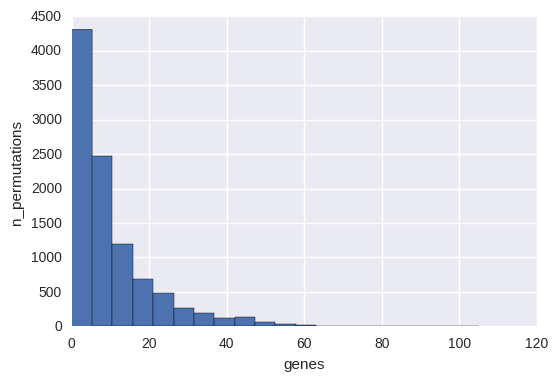

In [12]:
plt.hist(permuts,bins=20)
plt.xlabel("genes")
plt.ylabel("n_permutations")

In [11]:
x = eQTLdb[eQTLdb.rsid.isin(a_rs)].drop_duplicates()
print("rsid",len(set(x["rsid"].values)),len(aeQTL_rs))
x=x.merge(gwas["asthma"]
          ,left_on="rsid",right_on = "SNPS",how = "outer")

x = x.dropna(axis=0)
x = x[["chrom","pos","rsid","rsid_reported","gene","tissue","source", "cis_trans","CHR_ID","CHR_POS","MAPPED_GENE","CONTEXT","P-VALUE","DISEASE/TRAIT","PUBMEDID"]]
x = x.drop_duplicates()
x.to_csv(eQTL_dir+"Asthma.eQTL.tsv",sep = "\t",index=False)
#x["chrom","pos",""]
x = x [["rsid","gene","cis_trans"]].drop_duplicates()
print("all:",x.shape[0],"cis",x[x.cis_trans == "cis"].shape[0],
     "trans",x[x.cis_trans == "trans"].shape[0],"rsid",len(set(x["rsid"].values)),
      "genes",len(set(x["gene"].values)))

rsid 140 140
all: 1102 cis 882 trans 220 rsid 140 genes 439


In [12]:
x = eQTLdb[eQTLdb.rsid.isin(h_rs)].drop_duplicates()
x=x.merge(gwas["hypertension"]
          ,left_on="rsid",right_on = "SNPS",how = "outer")
x = x.dropna(axis=0)
x = x[["chrom","pos","rsid","rsid_reported","gene","tissue","source", "cis_trans","CHR_ID","CHR_POS","MAPPED_GENE","CONTEXT","P-VALUE","DISEASE/TRAIT","PUBMEDID"]]
x = x.drop_duplicates()
x.to_csv(eQTL_dir+"Hypertension.eQTL.tsv",sep = "\t",index=False)
x = x [["rsid","gene","cis_trans"]].drop_duplicates()
print("all:",x.shape[0],"cis",x[x.cis_trans == "cis"].shape[0],
     "trans",x[x.cis_trans == "trans"].shape[0],"rsid",len(set(x["rsid"].values)),
      "genes",len(set(x["gene"].values)))


all: 300 cis 244 trans 56 rsid 46 genes 213
